## ML 과제

과제할 때 꿀팁!

1. 이전 세션들에서의 자료를 찾아본다.
2. 질문방에 질문한다.
3. 구글링한다.
4. 복붙하지 않고 직접 타이핑해서 코드를 완성한다.

In [202]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

### 0. Titanic 데이터 로드 및 훓어보기

In [203]:
# 여러분이 이전 과제로 만드셨을 FE를 진행한 데이터 보다는 원본 데이터가 조금 더 이번 실습에 적합하기 때문에 원본을 사용하겠습니다.
# 데이터를 로드하고, 잘 불러와진 것인지 첫 5행을 불러와 확인해보세요.

titanic = pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [204]:
# 변수들의 데이터 타입, 결측치, target의 imbalance 여부를 확인해주세요.

titanic.info()
titanic.groupby("Survived").size()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Survived
0    549
1    342
dtype: int64

In [205]:
#Age 결측치를 저번 과제에서 Name 을 바탕으로 유추한 것을 이용하여 채워줍니다

temp = titanic.copy()
temp['Title'] = temp.Name.str.extract('([A-Za-z]+)\.')
temp['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],['Other']*14, inplace =True)
title_age = temp.groupby('Title')[['Age']].median()
title = title_age.index
age = title_age["Age"]
dict_title_age = dict(zip(title,age))
temp['Age'] = temp['Age'].fillna(temp['Title'].map(dict_title_age))
temp.head()
titanic = temp

In [206]:
# 편의상 결측치 데이터 및 승객 고유의 데이터('PassengerId','Name', 'Ticket', 'Cabin')는 모두 drop 시킵시다.
# 실제 프로젝트에서는 이렇게 하시면 성능이 낮을 수 있어요!!

temp = titanic
temp.drop(["PassengerId","Name","Ticket","Cabin","Title"], axis=1, inplace = True)
titanic = temp

In [91]:
# categorical feature(Sex, Embarked)에 대해 LabelEncoding을 진행해 주세요.
# 전처리 완료된 DataFrame을 첫 5행을 불러와 확인해보세요

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

temp = titanic
temp.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [207]:
label_encoder.fit(temp.Sex)
Sex_encoded = label_encoder.transform(temp.Sex)
temp.Sex = Sex_encoded
print(label_encoder.classes_, "=>", label_encoder.transform(label_encoder.classes_))


['female' 'male'] => [0 1]


In [208]:
temp.Embarked.fillna("Nan", inplace=True)
label_encoder.fit(temp.Embarked)
Embarked_encoded = label_encoder.transform(temp.Embarked)
temp.Embarked = Embarked_encoded
print(label_encoder.classes_, "=>", label_encoder.transform(label_encoder.classes_))
temp.head()
titanic = temp

['C' 'Nan' 'Q' 'S'] => [0 1 2 3]


### 1. Train-Test split & 종속변수-설명변수 분할

In [209]:
# 분할을 위해 필요한 적절한 패키지를 불러와주세요 
# train-test split 및 종속변수-설명변수 분할을 진행해주세요

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

y = titanic.Survived
X = titanic.drop('Survived',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 427)

### 2. Decision Tree를 통한 Classification

In [210]:
# Decision Tree에서 categorical feature인 'Pclass'를 기준으로 첫 번째 Node(Root Node)가 분리된다고 가정합시다.
# 이 때 Entropy 지표를 통해 Information Gain을 계산할 수 있는 함수(또는 코드)를 작성하고, Information gain을 계산하세요.
# 실습에서 다루지 않은 내용입니다. 코드가 어려우시다면 줄글로만 풀이과정을 작성해주셔도 됩니다.
import math

X.Pclass.value_counts()
not_survived = y.value_counts()[0]
survived = y.value_counts()[1]
sur_prob = survived / (survived + not_survived)
entropy_root = - (sur_prob * math.log(sur_prob,2) + (1-sur_prob) * math.log(1-sur_prob,2) )
inform_gain = entropy_root
entropy_child = []
for i in range(3):
    total_num = X.Pclass.value_counts()[i+1]
    survived = titanic.groupby('Pclass')['Survived'].sum()[i+1]
    prob = survived / total_num
    inform_gain -= ((- (prob * math.log(prob,2) + (1-prob) * math.log(1-prob,2) )) * (total_num / X.Pclass.count()))

inform_gain
# titanic data로 Pclass를 분리기준으로 이용했을 때의 entropy를 계산하는 상황만 고려하시면 됩니다.
# 계산에 사용할 데이터는 분할 이전의 0번에서 전처리 완료한 데이터를 기준으로 하겠습니다!
# 올바르게 계산할 시 Information Gain은 0.0097이 나옵니다.


0.0838310452960116

##### <b>줄글 답안</b>
>

In [211]:
# Decision Tree 모델을 사용하기 위한 적절한 패키지를 불러와 주세요
# 별 다른 parameter 설정 없이 객체를 만들어 주고, 학습을 진행하세요

df_clf = DecisionTreeClassifier()

df_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 3. Graphviz를 통한 시각화

graphviz 설치를 하지 않으셨거나 오류가 난다면 이 부분은 건너뛰셔도 좋습니다

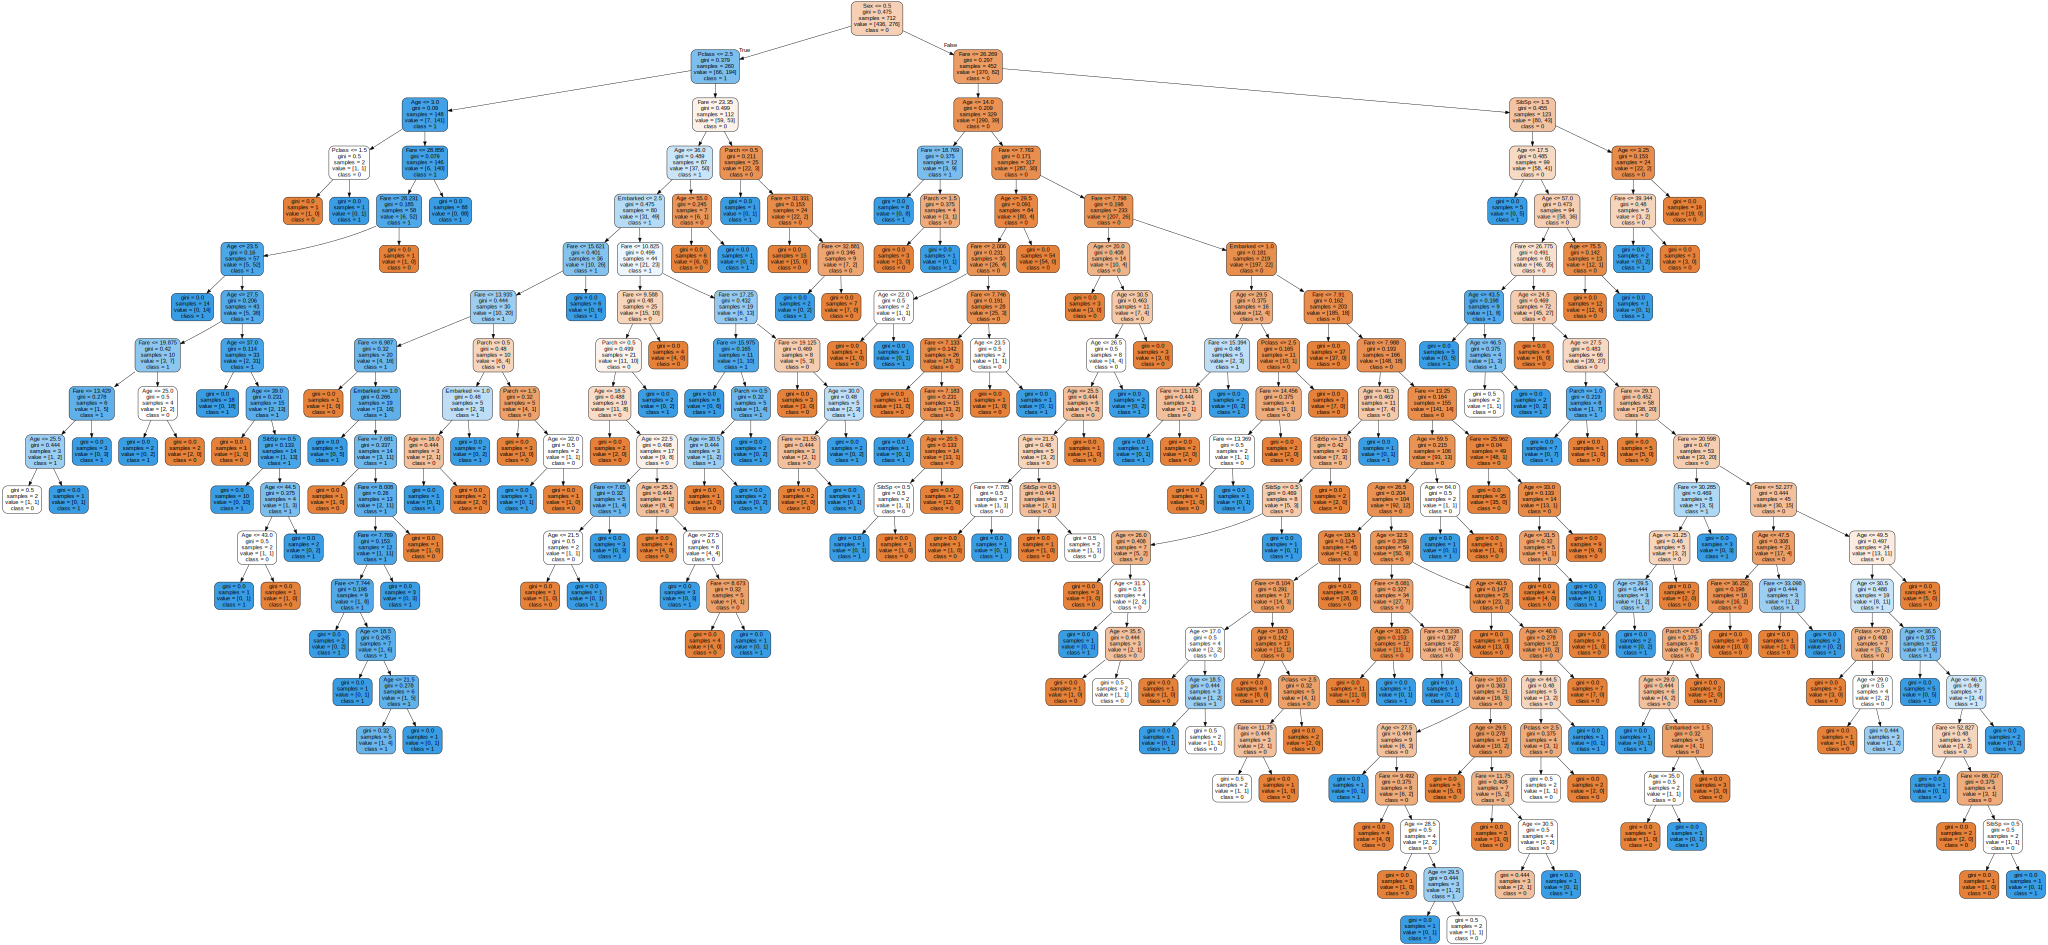

In [213]:
from sklearn.tree import export_graphviz

export_graphviz(df_clf,
                out_file=("titanic_hw.dot"),
                feature_names=X_train.columns,
                class_names=['0','1'],
                rounded=True,
                filled=True)

import graphviz
import os

os.environ["PATH"] += os.pathsep + '/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2/bin'

with open("titanic_hw.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### 4. 결과 확인

In [223]:
# accuracy, f1 score, roc_auc score, confusion matrix, classification report를 모두 불러와주세요
# 불러온 metric(결과 확인 지표)들을 통해 결과를 확인해주세요.
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
prediction = df_clf.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test,prediction)),
                           'F1_Score: {}'.format(f1_score(y_test,prediction)),
                           'ROC_AUC_Score: {}'.format(roc_auc_score(y_test,prediction)),sep='\n')

matrix = confusion_matrix(y_test,prediction)
print(matrix)
print(classification_report(y_test,prediction))

Accuracy: 0.7597765363128491
F1_Score: 0.6766917293233083
ROC_AUC_Score: 0.7435639581657281
[[91 22]
 [21 45]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       113
           1       0.67      0.68      0.68        66

   micro avg       0.76      0.76      0.76       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



### 5. GridSearch를 통한 Tree pruning

In [235]:
# GridSearch를 위한 적절한 패키지를 불러와 주세요
# max_leaf_nodes를 제외한 3가지 이상의 parameter에 대한 GridSearch를 진행해주세요. scoring은 원하시는 지표로 하셔도 됩니다.

from sklearn.model_selection import GridSearchCV
grid_dt = DecisionTreeClassifier()

criterion = ['gini','entropy']
max_depth = [3,4,5]
min_samples_split = [2,3,4]

parameter_grid = {'criterion':criterion,'max_depth':max_depth,'min_samples_split':min_samples_split}

gs = GridSearchCV(estimator=grid_dt,param_grid = parameter_grid, scoring='roc_auc')

gs.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [236]:
# 최적 parameter 조합 / Validation score / Test score를 확인해 주세요.

print('최적 Parameter: {}'.format(gs.best_params_),
     '최고 Validation Score: {:.3f}'.format(gs.best_score_),sep='\n')

최적 Parameter: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
최고 Validation Score: 0.850


## GridSearch에 사용하신 parameter는 Decision Tree 모델 학습에서 어떤 역할을 하는지 간단하게 요약해주세요.
## ex) criterion은 decision tree의 분류 기준인 불순도 지표를 정한다.
## hint) Shift+tab
criterion은 decision tree의 분류 기준인 불순도 지표를 정한다
max_depth는 트리의 최대 깊이를 정한다. 너무 깊으면 과적합이 이뤄질 수 있다.
min_samples_split 은 노드를 분할하기 위한 최소한의 샘플 데이터 수를 말한다. 너무 적으면 과적합이 일어날 수 있다.


> ### <b>고생하셨습니다~</b>

생각보다 GridSearch의 결과가 안 좋게 나와서 이상하다 생각하신 분들도 있을 수 있습니다. GridSearch 특성상 기존에 정해준 parameter 범위 내에서 찾는 것이기 때문에 애초에 적절한 parameter 후보를 찾지 못했다면 성능이 안 좋을 수도 있습니다. 앞으로 여러 프로젝트 진행해보시면서, parameter 찾는 것에 대한 감도 스스로 익혀보시면 좋을 것 같습니다!